<h1>04 模型训练<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#准备工作" data-toc-modified-id="准备工作-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>准备工作</a></span><ul class="toc-item"><li><span><a href="#引入代码包" data-toc-modified-id="引入代码包-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>引入代码包</a></span></li><li><span><a href="#全局参数" data-toc-modified-id="全局参数-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>全局参数</a></span></li><li><span><a href="#特征读取" data-toc-modified-id="特征读取-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>特征读取</a></span></li><li><span><a href="#模型训练代码" data-toc-modified-id="模型训练代码-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>模型训练代码</a></span></li></ul></li><li><span><a href="#简单特征f1训练" data-toc-modified-id="简单特征f1训练-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>简单特征f1训练</a></span><ul class="toc-item"><li><span><a href="#数据读取" data-toc-modified-id="数据读取-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>数据读取</a></span></li><li><span><a href="#逻辑回归" data-toc-modified-id="逻辑回归-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>逻辑回归</a></span></li><li><span><a href="#朴素贝叶斯" data-toc-modified-id="朴素贝叶斯-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>朴素贝叶斯</a></span></li><li><span><a href="#决策树" data-toc-modified-id="决策树-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>决策树</a></span></li><li><span><a href="#随机森林" data-toc-modified-id="随机森林-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>随机森林</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#用不同的特征训练，对比分析" data-toc-modified-id="用不同的特征训练，对比分析-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>用不同的特征训练，对比分析</a></span><ul class="toc-item"><li><span><a href="#读取数据" data-toc-modified-id="读取数据-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>读取数据</a></span></li><li><span><a href="#对比分析" data-toc-modified-id="对比分析-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>对比分析</a></span></li><li><span><a href="#结果输出" data-toc-modified-id="结果输出-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>结果输出</a></span></li></ul></li></ul></div>

# 准备工作

## 引入代码包

In [1]:
from sklearn import metrics  
import numpy as np  
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
#########SKLearn 集成的算法###############
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree  
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB 
#########SKLearn 集成的算法###############
from sklearn.model_selection import train_test_split # 切分数据
from sklearn.metrics import mean_squared_error #评价指标

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

## 全局参数

In [2]:
############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
myeval='roc_auc'
cvscore=0
############目录定义#################################
datapath = '' 
featurepath = 'feature/' 
resultpath = 'result/'
tmppath = 'tmp/'
scorepath = 'score/'
###########工具函数#############################################

## 特征读取

In [3]:
###########工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename): 
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename): 
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    df.fillna(0,inplace=True)
    return df

#按特征名读取数据
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf,testdf  

## 模型训练代码

In [4]:
# 将特征归一化
def standize_df(train_data,test_data):
    from sklearn import preprocessing 
    
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler[id_col_names] = train_data[id_col_names]
    test_data_scaler[id_col_names] = test_data[id_col_names]
    return train_data_scaler,test_data_scaler

In [5]:
####################部分整合在sklearn的分类算法###############
def get_sklearn_model(model_name):
    #朴素贝叶斯
    if model_name=='NB':
        return MultinomialNB(alpha=0.01)
    #逻辑回归
    elif model_name=='LR':
        return LogisticRegression(penalty='l2') 
    # KNN  
    elif model_name=='KNN':
        return KNeighborsClassifier()  
    #随机森林
    elif model_name=='RF':
        return RandomForestClassifier()  
    #决策树
    elif model_name=='DT':
        return tree.DecisionTreeClassifier()  
    #向量机
    elif model_name=='SVC':
        return SVC(kernel='rbf')
    #GBDT
    elif model_name=='GBDT':
        return GradientBoostingClassifier()
    #XGBoost
    elif model_name=='XGB':
        return XGBClassifier()
    #lightGBM
    elif model_name=='LGB':
        return LGBMClassifier()
    else:
        print("wrong model name!")


#画学习曲线
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv,scoring=myeval, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt

#画算法的学习曲线,为加快画图速度，最多选20%数据
def plot_curve_single(traindf,classifier,cvnum,train_sizes=[0.01,0.02,0.05,0.1,0.2,0.3]): 
    X=get_predictors_df(traindf)
    y=get_target_df(traindf)
    estimator = get_sklearn_model(classifier)    #建模
    title = "learning curve of "+classifier+", cv:"+str(cvnum)
    plot_learning_curve(estimator, title, X, y, ylim=(0, 1.01), cv=cvnum, train_sizes=train_sizes)


#性能评价函数
#本赛题目标是预测投放的优惠券是否核销。
#针对此任务及一些相关背景知识，使用优惠券核销预测的平均AUC（ROC曲线下面积）作为评价标准。 
#即对每个优惠券coupon_id单独计算核销预测的AUC值，再对所有优惠券的AUC值求平均作为最终的评价标准。
# coupon平均auc计算
def myauc(test):
    testgroup = test.groupby(['coupon_id'])
    aucs = []
    for i in testgroup:
        coupon_df = i[1]
        #测算AUC必须大于1个类别
        if len(coupon_df['label'].unique()) < 2:
            continue
        auc = metrics.roc_auc_score(coupon_df['label'], coupon_df['pred'])
        aucs.append(auc)
    return np.average(aucs)

#按照日期分割
def test_model(traindf,classifier):
    train=traindf[traindf.date_received<20160515].copy()
    test=traindf[traindf.date_received>=20160515].copy()

    train_data = get_predictors_df(train).copy()
    train_target = get_target_df(train).copy()
    test_data = get_predictors_df(test).copy()
    test_target = get_target_df(test).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result=clf.predict_proba(test_data)[:,1]
    test['pred']=result
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+" 总体 AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)


def test_model_split(traindf,classifier):
    target = get_target_df(traindf).copy()
    
    train_all,test_all,train_target,test_target=train_test_split(traindf,target,test_size=0.2,random_state=0)
    
    train_data = get_predictors_df(train_all).copy()
    test_data = get_predictors_df(test_all).copy()
    
    clf = get_sklearn_model(classifier)
    clf.fit(train_data, train_target)
    result=clf.predict_proba(test_data)[:,1]
    
    test=test_all.copy()
    test['pred']=result
    
    score = metrics.roc_auc_score(test_target, result)
    print(classifier+"总体AUC:", score)
    score_coupon = myauc(test)
    print(classifier+" Coupon AUC:", score_coupon)

# 简单特征f1训练

## 数据读取

In [6]:
#所有的特征都是上一节生成的
train_f1,test_f1=read_data('f1')
#因为要使用KNN等进行测试，所以需要归一化
train_f1,test_f1=standize_df(train_f1,test_f1)

In [7]:
train_f1.shape

(304509, 9)

In [8]:
train_f1['label'].sum()

27878

In [9]:
train_f1.head()

,discount_rate,distance,if_fd,full_value,reduction_value,label,user_id,coupon_id,date_received
0,0.812785,0.1,1.0,0.500000,0.20,0,1439408,11002,20160528
1,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160613
2,0.939117,0.0,1.0,0.066667,0.01,0,1439408,8591,20160516
3,0.761035,0.0,1.0,0.100000,0.05,0,2029232,1532,20160530
4,0.939117,0.0,1.0,0.066667,0.01,0,2029232,12737,20160519


## 逻辑回归

In [10]:
test_model(train_f1,'LR')

LR 总体 AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647


LR Coupon AUC


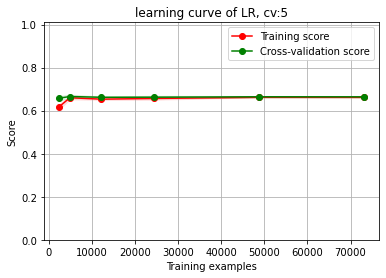

In [11]:
print('LR Coupon AUC')
plot_curve_single(train_f1,'LR',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## 朴素贝叶斯

In [12]:
test_model(train_f1,'NB')

NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647


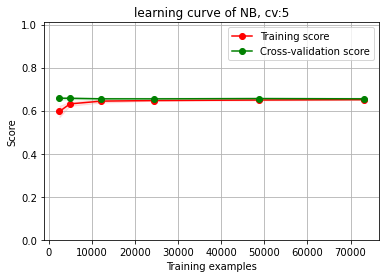

In [13]:
plot_curve_single(train_f1,'NB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## 决策树

In [14]:
test_model(train_f1,'DT')

DT 总体 AUC: 0.6481609737147687
DT Coupon AUC: 0.5302514392404754


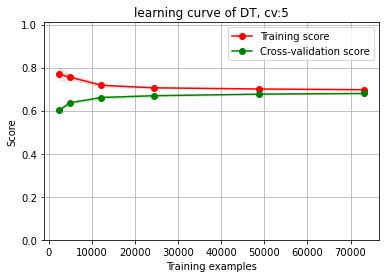

In [15]:
plot_curve_single(train_f1,'DT',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## 随机森林

In [16]:
test_model(train_f1,'RF')

RF 总体 AUC: 0.6476377093686134
RF Coupon AUC: 0.5300404304810895


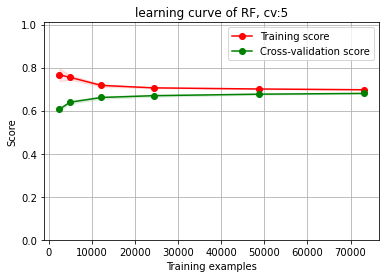

In [17]:
plot_curve_single(train_f1,'RF',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## LightGBM

In [18]:
test_model(train_f1,'LGB')

LGB 总体 AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097


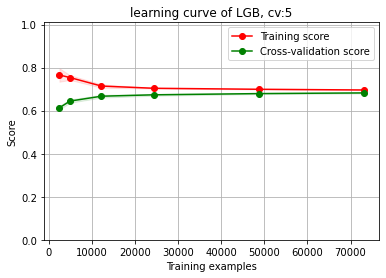

In [19]:
plot_curve_single(train_f1,'LGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

## XGBoost

In [20]:
test_model(train_f1,'XGB')

[23:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB 总体 AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699


[23:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


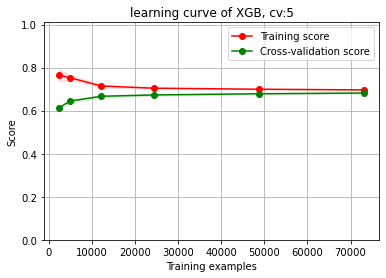

In [21]:
plot_curve_single(train_f1,'XGB',5,[0.01,0.02,0.05,0.1,0.2,0.3])

# 用不同的特征训练，对比分析

## 读取数据

In [22]:
#所有的特征都是上一节生成的
train_f2,test_f2=read_data('sf2')
#因为要使用KNN等进行测试，所以需要归一化
train_f2,test_f2=standize_df(train_f2,test_f2)

#所有的特征都是上一节生成的
train_f3,test_f3=read_data('sf3')
#因为要使用KNN等进行测试，所以需要归一化
train_f3,test_f3=standize_df(train_f3,test_f3)

In [23]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


## 对比分析

In [24]:
print('特征f1逻辑回归成绩')
test_model(train_f1,'LR')
print('特征sf2逻辑回归成绩')
test_model(train_f2,'LR')
print('特征sf3逻辑回归成绩')
test_model(train_f3,'LR')

特征f1逻辑回归成绩
LR 总体 AUC: 0.6653536857862119
LR Coupon AUC: 0.5381247642711647
特征sf2逻辑回归成绩
LR 总体 AUC: 0.7602600585801952
LR Coupon AUC: 0.6030222638146623
特征sf3逻辑回归成绩
LR 总体 AUC: 0.8100277745019229
LR Coupon AUC: 0.7290105045591566


In [25]:
print('特征f1朴素贝叶斯成绩')
test_model(train_f1,'NB')
print('特征sf2朴素贝叶斯成绩')
test_model(train_f2,'NB')
print('特征sf3朴素贝叶斯成绩')
test_model(train_f3,'NB')

特征f1朴素贝叶斯成绩
NB 总体 AUC: 0.6670944091690476
NB Coupon AUC: 0.5381247642711647
特征sf2朴素贝叶斯成绩
NB 总体 AUC: 0.7344423297904361
NB Coupon AUC: 0.6063348733663753
特征sf3朴素贝叶斯成绩
NB 总体 AUC: 0.7812536906026242
NB Coupon AUC: 0.7119101448923768


In [26]:
print('特征f1决策树成绩')
test_model(train_f1,'DT')
print('特征sf2决策树成绩')
test_model(train_f2,'DT')
print('特征sf3决策树成绩')
test_model(train_f3,'DT')

特征f1决策树成绩
DT 总体 AUC: 0.6481609737147687
DT Coupon AUC: 0.5302514392404754
特征sf2决策树成绩
DT 总体 AUC: 0.5236872717834878
DT Coupon AUC: 0.5195167456384611
特征sf3决策树成绩
DT 总体 AUC: 0.5750017774238598
DT Coupon AUC: 0.5703603468083985


In [27]:
print('特征f1随机森林成绩')
test_model(train_f1,'RF')
print('特征sf2随机森林成绩')
test_model(train_f2,'RF')
print('特征sf3随机森林成绩')
test_model(train_f3,'RF')

特征f1随机森林成绩
RF 总体 AUC: 0.6477365430962428
RF Coupon AUC: 0.5304866315953284
特征sf2随机森林成绩
RF 总体 AUC: 0.6887468678262609
RF Coupon AUC: 0.5663048932517719
特征sf3随机森林成绩
RF 总体 AUC: 0.7750583153922534
RF Coupon AUC: 0.7081219706368526


In [28]:
print('特征f1 LightGBM成绩')
test_model(train_f1,'LGB')
print('特征sf2  LightGBM成绩')
test_model(train_f2,'LGB')
print('特征sf3  LightGBM成绩')
test_model(train_f3,'LGB')

特征f1 LightGBM成绩
LGB 总体 AUC: 0.6534077718076291
LGB Coupon AUC: 0.5327884933599097
特征sf2  LightGBM成绩
LGB 总体 AUC: 0.7741029767659218
LGB Coupon AUC: 0.5984526360012944
特征sf3  LightGBM成绩
LGB 总体 AUC: 0.8284887876924993
LGB Coupon AUC: 0.7374344321731373


In [29]:
print('特征f1 XGBoost成绩')
test_model(train_f1,'XGB')
print('特征sf2  XGBoost成绩')
test_model(train_f2,'XGB')
print('特征sf3  XGBoost成绩')
test_model(train_f3,'XGB')

特征f1 XGBoost成绩
[23:27:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB 总体 AUC: 0.6537138075207527
XGB Coupon AUC: 0.531849037296699
特征sf2  XGBoost成绩
[23:27:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB 总体 AUC: 0.7274131700360452
XGB Coupon AUC: 0.5886899184606202
特征sf3  XGBoost成绩
[23:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic'

可以发现特征f2比特征f1的结果好很多，这是因为特征2使用滑窗方案，增加了很多统计特征。而特征3比特征又有了很大的提高，这是因为特征3增加了穿越特征。

对比LightGBM和LR的成绩可以发现对于本问题，LightGBM有着更好的成绩。    

## 结果输出

通过分析发现特征sf3版本通过lightGBM分析的结果不错。下一步要做的事就是输出结果。

In [30]:
train_f3.head()

,discount_rate,distance,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,total_coupon,merchant_distance_min,merchant_distance_max,...,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label,user_id,coupon_id,date_received
0,0.863014,0.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,1832624,7610,20160429
1,0.786910,1.0,1.0,0.666667,0.30,0.037988,0.043496,0.214299,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,163606,5054,20160421
2,0.863014,0.2,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,94107,7610,20160412
3,0.863014,1.0,1.0,0.666667,0.20,0.722209,0.898094,1.000000,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,7610,20160426
4,0.761035,1.0,1.0,0.100000,0.05,0.302988,0.392295,0.209746,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4061024,9871,20160409


In [31]:
#预测函数
def classifier_df_simple(train_feat, test_feat,classifier):
    model = get_sklearn_model(classifier)    
    model.fit(get_predictors_df(train_feat), get_target_df(train_feat))    
    predicted = pd.DataFrame(model.predict_proba(get_predictors_df(test_feat))[:,1])
    return predicted

#输出结果函数
def output_predicted(predicted,resultfile,test_feat):
    predicted=round(predicted,3)
    resultdf=get_id_df(test_feat).copy()
    resultdf['Probability']=predicted
    return resultdf

In [32]:
predicted=classifier_df_simple(train_f3, test_f3,'LGB')

In [33]:
predicted.head()

,0
0,0.007423
1,0.132002
2,0.006900
3,0.012854
4,0.035856


In [34]:
#生成结果数据
result=output_predicted(predicted,'sf3_LGB.csv',test_f3)

In [35]:
result.head()

,user_id,coupon_id,date_received,Probability
0,4129537,9983,20160712,0.007
1,6949378,3429,20160706,0.132
2,2166529,6928,20160727,0.007
3,2166529,1808,20160727,0.013
4,6172162,6500,20160708,0.036


In [36]:
#输出结果
result.to_csv('sf3_lgb.csv',header=False,index=False,sep=',')

在代码目录下生成了sf3_lgb.csv，这个结果就可以提交了。